## MRI PREPROC AND SOURCE LOCALISATION

**This script:**
1. Extracts fs files from archives (receied from Linux computer after MRI segmentation and creating BEM models)
2. Sets EEG montage with new electrode locations from Brainsight digitizer files
3. Allows to use GUI to coregister electrodes to the head (manually) -> creates trans files
4. Computes source space, BEM model, and forward solution
5. Computes data and noise covariance matrices
6. Creates and applies LCMV beamformer
7. Morphs sources of each subject into the fsaverage brain

**OUTCOME: Source time courses for each epoch and each subject for planning and execution in BL and MAIN tasks**

In [2]:
import pandas as pd
import numpy as np
import os
from utils import check_paths
import shutil
import re
from pathlib import Path
import nibabel
import tarfile

import mne
from mne.io.constants import FIFF
from mne.transforms import apply_trans
from mne.datasets import fetch_fsaverage
from mne.beamformer import apply_lcmv, make_lcmv, apply_lcmv_epochs
from mne.datasets import fetch_fsaverage, sample
from mne import compute_rank

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
%matplotlib qt


__________________

**1. EXTRACT FILES FROM ARCHIVES**

In [ ]:
#! sub07 was faulty (had many subfolders in the archive), beeded manual extraction
# DONE!

# Base directory containing subject folders or archives
fs_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir'
groups = ["Y", "O"]

for group in groups:
    base_dir = os.path.join(fs_dir, group)

    # List all items in the directory
    for file_name in os.listdir(base_dir):

        # Construct the full file path
        file_path = os.path.join(base_dir, file_name)

        # Check for tar or zip archive
        if file_name.endswith('.tar') or file_name.endswith('.tar.gz'):
            sub_name = os.path.splitext(os.path.splitext(file_name)[0])[0]  # removes .tar/.gz
            # extract_dir = os.path.join(base_dir, sub_name)
            
            os.makedirs(base_dir, exist_ok=True)
            print(f'Extracting {file_name} to {base_dir}...')

            with tarfile.open(file_path, 'r') as tar:
                tar.extractall(path=base_dir)

print('All archives processed.')


_____________________________

**Sanity check: visualisation of FS files (optional)**

In [67]:
# subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs'
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
subject = "s1_pac_sub01"
t1_fname = os.path.join(subjects_dir, subject, "mri", "T1.mgz")
t1 = nibabel.load(t1_fname)
t1.orthoview()

<OrthoSlicer3D: D:/BonoKat/research project/# study 1/mri_data/fs_output/freesurfer/sub_dir/Y/s1_pac_sub01/mri/T1.mgz (256, 256, 256)>

Traceback (most recent call last):
  File "d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
TypeError: OrthoSlicer3D._cleanup() takes 1 positional argument but 2 were given


In [ ]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

Check BEM surfaces (optional)

In [ ]:
bem_path = os.path.join(subjects_dir, subject, 'bem', f"{subject}-head.fif")
surfaces = mne.read_bem_surfaces(bem_path)

In [ ]:
# Try reading a cortical surface (e.g., lh.pial)
surf_path = f"{subjects_dir}/{subject}/surf/lh.pial"
coords, faces = mne.read_surface(surf_path)
print(f"✅ Surface loaded. Vertices: {len(coords)}, Faces: {len(faces)}")


✅ Surface loaded. Vertices: 134495, Faces: 268986


In [32]:
# Test a cortical surface
coords, faces = mne.read_surface(f"{subjects_dir}/{subject}/surf/lh.pial")
print(f"✅ lh.pial loaded: {len(coords)} vertices, {len(faces)} faces")

✅ lh.pial loaded: 134495 vertices, 268986 faces


___

# GROUP ANALYSIS

**2. SET EEG MONTAGE FROM DIGITIZER FILES**

In [ ]:
# SET EEG MONTAGE FROM DIGITIZER FILES
# DONE

eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'

groups = ['Y', 'O']
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go']
block_names = ['_baseline', '_adaptation']

for group in groups:
    dig_folder = f'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\{group}'
    dig_group_dir = os.path.join(eeg_data_dir, group)
    subjects_dir = os.path.join(eeg_data_dir, group)

    for subject in os.listdir(subjects_dir):
        eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
        analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
        source_path = os.path.join(analysis_path, 'source')
        check_paths(source_path)

        ######## ADJUST DIGITIZER FILES AND CREATE MONTAGE ########
        dig_file = os.path.join(dig_folder, f"{subject}.txt")

        # Set the header line
        column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
        cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

        # Load the data, skipping the header lines
        dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
        dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
        dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
        dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
        dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

        # Convert mm to m
        dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

        # EEG electrodes
        eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
        eeg_pos = dict(zip(
            eeg_df['Electrode Name'],
            np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
        ))

        # Fiducials
        fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
        fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
                for _, row in fid_df.iterrows()}

        # Lowercase the montage keys to match MNE style
        montage_renamed = {
            k.strip().capitalize(): v for k, v in eeg_pos.items()
        }
        # Create montage
        montage = mne.channels.make_dig_montage(
            ch_pos=eeg_pos,
            # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
            # lpa=fid_pos['lpa'],
            # rpa=fid_pos['rpa'],
            coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
        )

        ######## READ ALL EPOCHS FILES AND SET MONTAGE ########
        # Loop through all task stages and blocks
        for task in tasks:
            for task_stage in task_stages:
                if task == '_BL':
                    epochs_file = os.path.join(analysis_path, f'{subject}{task}_epochs{task_stage}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)
                    epochs.set_montage(montage, match_case=False)
                    epochs.save(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'), overwrite=True)
                else:
                    for block_name in block_names:
                        epochs_file = os.path.join(analysis_path, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                        epochs = mne.read_epochs(epochs_file)
                        epochs.set_montage(montage, match_case=False)
                        epochs.save(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-epo_montage.fif'), overwrite=True)


**3. COREGISTRATION (manual)**

In [ ]:
# MANUAL COREGISTRATION: 1 recording per subject
# DONE for younger group

group = 'Y'
task = '_BL'
task_stage = '_plan'
fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
subjects_dir = os.path.join(eeg_data_dir, group)
subject = os.listdir(subjects_dir)[0] # change index to select a subject
print(f'Selecting subject: {subject}')

eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
source_path = os.path.join(analysis_path, 'source')

info = os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif')
mne.gui.coregistration(subject=subject,
                    subjects_dir=fs_subjects_dir,
                    inst=info,
                    )

# COREG CHECK
# trans_file = os.path.join(source_path, f'{subject}-trans.fif')
# trans = mne.read_trans(trans_file)
# mne.gui.coregistration(subject=subject,
#                     subjects_dir=fs_subjects_dir,
#                     inst=info,
#                     trans=trans_file
#                     )

In [ ]:
# CHECK COREGISTRATION
# optional

subject = os.listdir(subjects_dir)[0]
eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
source_path = os.path.join(analysis_path, 'source')
epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))

trans_file = os.path.join(source_path, f'{subject}-trans.fif')
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info=epochs.info,
    trans=trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=fs_subjects_dir,
    surfaces=["head-dense"],
)

subs 26 and 43 - manually fixed inner surface to fit into outer surface 

**4. Source space, BEM model, and forward solution**

In [ ]:
# SOURCE SPACE
# DONE for younger group

eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
task = '_BL'
task_stage = '_plan' # any task / stage can be used, since the source space is the same for all tasks
groups = ['Y'] # 'O'
conductivity = (0.3, 0.006, 0.3)  # for three layers

for group in groups:
    fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
    subjects_list = [folder.name for folder in os.scandir(fs_subjects_dir) if folder.is_dir()]

    for subject in subjects_list:
        print(f"Setting up source space for subject: {subject}")
        source_path = os.path.join(eeg_data_dir, group, subject, 'preproc', 'analysis', 'source')

        # Set up the source space
        src = mne.setup_source_space(
            subject,
            spacing="ico4", # ico4 - 2562 vertices per hemisphere
            add_dist="patch"
            subjects_dir=fs_subjects_dir 
        )

        # BEM model
        model = mne.make_bem_model(
            subject=subject, ico=4, conductivity=conductivity, subjects_dir=fs_subjects_dir
        )
        bem = mne.make_bem_solution(model)

        # Forward solution
        epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))
        trans_file = os.path.join(source_path, f'{subject}-trans.fif')
        trans = mne.read_trans(trans_file)
        
        fwd = mne.make_forward_solution(
            info=epochs.info,
            trans=trans,
            src=src,
            bem=bem,
            eeg=True,
            n_jobs=-1
        )
        print(fwd)

        # SAVE source space, BEM model, and forward solution
        # Save the source space
        src_fname = os.path.join(source_path, f"{subject}-ico4-src.fif")
        mne.write_source_spaces(src_fname, src, overwrite=True)

        # Save BEM model
        bem_model_fname = os.path.join(source_path, f"{subject}-bem-model.fif")
        mne.write_bem_surfaces(bem_model_fname, model, overwrite=True)

        # Save BEM solution
        bem_sol_fname = os.path.join(source_path, f"{subject}-bem-sol.fif")
        mne.write_bem_solution(bem_sol_fname, bem, overwrite=True)

        # Save forward solution
        fwd_fname = os.path.join(source_path, f"{subject}-fwd.fif")
        mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

        print(f"Saved all source modeling files to: {source_path}")

______________________

# LCMV

*Inverse operator - on evoked (higher snr); sources - on epochs (for PAC)*

**5. DATA and NOISE COVARIANCE MATRICES**

In [ ]:
# COMPUTE DATA and NOISE COVARIANCE MATRICES
# DONE for YOUNGER group

# eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
groups = ['Y'] # 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # any task / stage can be used, since the source space is the same for all tasks
block_names = ['_baseline', '_adaptation']
rank_info = []

for group in groups:
    eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

    for subject in os.listdir(eeg_data_dir):
        print(f"Setting up source space for subject: {subject}")
        analysis_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis')
        source_path = os.path.join(analysis_dir, 'source')

        for task in tasks:
            for task_stage in task_stages:
                for block_name in block_names:
                    if task == '_BL':
                        block_name = ''
                    else:
                        block_name = block_name
                    
                    epochs_file = os.path.join(analysis_dir, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)

                    #! Change baseline for prestim period to get more different data and noise covariance matrices
                    epochs.apply_baseline(baseline=(-0.5, -0.001))
                    #! overwrite epochs with new baseline
                    epochs.save(os.path.join(analysis_dir, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif'), overwrite=True)

                    # evoked = epochs.average()
                    # evoked.plot()

                    rank = compute_rank(epochs, info=epochs.info) # check for rank deficiency - ALL GOOD: all epochs have rank 59
                    rank_info.append(f'Rank for {subject}{task}{task_stage}{block_name}: {rank}')

                    # Compute data and noise covariance matrices
                    data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.5, method='auto', rank='info')
                    # data_cov.plot(epochs.info)

                    noise_cov = mne.compute_covariance(epochs, tmin=-0.5, tmax=-0.001, method='auto', rank='info') # Use method='auto' when you want safe defaults for source localization and don't want to hand-tune covariance
                    # noise_cov.plot(epochs.info)

                    # Save covariance matrices
                    mne.write_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-data-cov.fif'), data_cov, overwrite=True)
                    mne.write_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-noise-cov.fif'), noise_cov, overwrite=True)
                    print(f"Covariance matrices saved for {subject}{task}{task_stage}{block_name}")
print(rank_info)

**6. COMPUTE AND APPLY LCMV FILTERS**

In [ ]:
# COMPUTE AND APPLY LCMV FILTERS
# DONE for YOUNGER group

groups = ['Y'] # 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # any task / stage can be used, since the source space is the same for all tasks
block_names = ['_baseline', '_adaptation']

for group in groups:
    eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

    for subject in [os.listdir(eeg_data_dir)][0]:
        print(f"Setting up source space for subject: {subject}")
        analysis_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis')
        source_path = os.path.join(analysis_dir, 'source')
        stcs_folder = os.path.join(source_path, 'stcs')
        check_paths(stcs_folder)

        fwd_fname = os.path.join(source_path, f"{subject}-fwd.fif")
        forward = mne.read_forward_solution(fwd_fname)

        # Convert to fixed orientation (normal to cortex) AFTER computing the forward model
        fwd_fixed = mne.convert_forward_solution(forward, surf_ori=True, force_fixed=True)

        for task in tasks:
            for task_stage in task_stages:
                for block_name in block_names:
                    if task == '_BL':
                        block_name = ''
                    else:
                        block_name = block_name
                    
                    # Read epochs file
                    epochs_file = os.path.join(analysis_dir, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)
                    evoked = epochs.average()

                    # Read data and noise covariance matrices
                    data_cov = mne.read_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-data-cov.fif'))
                    noise_cov = mne.read_cov(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-noise-cov.fif'))
                    # Compute LCMV filters
                    filters = make_lcmv(
                                        evoked.info,
                                        fwd_fixed,
                                        data_cov,
                                        reg=0.05,
                                        noise_cov=noise_cov,
                                        pick_ori=None, # must be None when using fixed orientation
                                        weight_norm='unit-noise-gain-invariant',
                                        rank=None,
                                    )
                    print(f"LCMV filters computed for {subject}{task}{task_stage}{block_name}")

                    # Apply LCMV filters to epochs
                    stcs = apply_lcmv_epochs(epochs, filters)
                    print(f"LCMV filters applied to epochs for {subject}{task}{task_stage}{block_name}")

                    # Save filters
                    filters_fname = os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-filters-lcmv.h5')
                    filters.save(filters_fname, overwrite=True)
                    
                    # Save source time courses
                    for i, stc in enumerate(stcs):
                        stc.save(os.path.join(stcs_folder, f'{subject}{task}{task_stage}{block_name}-stc-lcmv_epoch_{i:03d}'))
                    print(f"Source time courses saved for {subject}{task}{task_stage}{block_name}")

Move source estimates to subfolders

In [ ]:
# Set your source directory (where the original STC files are located)
# DONE
group = 'Y'
eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

for subject in os.listdir(eeg_data_dir)[1:]:
    src_dir = Path(os.path.join(eeg_data_dir, subject, 'preproc', 'analysis', 'source', 'stcs'))

    # Set your destination directory
    dest_root = src_dir

    # Regex to parse the filename
    # Example: s1_pac_sub01_MAIN_plan_baseline-stc-lcmv_epoch_000-lh.stc
    pattern = re.compile(r'^(?P<subject>\w+)(?P<task>_BL|_MAIN)(?P<stage>_plan|_go)(?P<block>_baseline|_adaptation)?-stc-lcmv_epoch_\d+-[lr]h\.stc$')

    # Go through all STC files
    for file in src_dir.glob('*-stc-lcmv_epoch_*-??.stc'):
        match = pattern.match(file.name)
        if not match:
            print(f"Skipping unrecognized file: {file.name}")
            continue

        task = match.group('task')          # BL or MAIN
        stage = match.group('stage')        # plan or go
        block = match.group('block')        # baseline or adaptation (could be None for BL)

        # Build the destination path
        if task == '_BL':
            dest_path = dest_root / '_BL' / stage
        elif task == '_MAIN':
            if block is None:
                print(f"Missing block name for _MAIN task in file: {file.name}")
                continue
            dest_path = dest_root / '_MAIN' / stage / block
        else:
            print(f"Unknown task type: {task}")
            continue

        # Create destination folder if it doesn't exist
        dest_path.mkdir(parents=True, exist_ok=True)

        # Move the file (change to `shutil.copy` if you prefer to copy)
        shutil.move(str(file), dest_path / file.name)
        print(f"Moved {file.name} -> {dest_path}")


**7. Morphing the sources to the default brain**

In [ ]:
# Create a source space for the default brain
# DONE

mri_data_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
fs_subject = 'fsaverage_bem'

src = mne.setup_source_space(subject=fs_subject,
                              spacing="ico4",  # alternatives: 'oct5', 'ico5', 'ico4', etc.
                              add_dist="patch",
                              subjects_dir=mri_data_dir
                              )

mne.write_source_spaces(f'{mri_data_dir}/{fs_subject}/bem/fsaverage-ico4-src.fif', src)

In [ ]:
# Create subfolders for morphed STCs
# DONE

group = 'Y'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go']
block_names = ['_baseline', '_adaptation']
eeg_data_dir = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group}'

for subject in os.listdir(eeg_data_dir):
    analysis_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis')
    source_path = os.path.join(analysis_dir, 'source')
    morphed_folder = os.path.join(source_path, 'morphed_stcs')
    check_paths(morphed_folder)

    for task in tasks:
        task_folder = os.path.join(morphed_folder, task)
        check_paths(task_folder)
        for task_stage in task_stages:
            task_stage_folder = os.path.join(task_folder, task_stage)
            check_paths(task_stage_folder)
            for block_name in block_names:
                if task == '_BL':
                    block_name = ''
                else:
                    block_name = block_name
                    bloch_name_folder = os.path.join(task_stage_folder, block_name)
                    check_paths(bloch_name_folder)
    print(f"Morphed STCs folders created for subject: {subject}")


In [92]:
# MORPH SOURCE ESTIMATES TO FSAVERAGE SPACE
# DONE for YOUNGER group

groups = ['Y'] # 'O'
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # any task / stage can be used, since the source space is the same for all tasks
block_names = ['_baseline', '_adaptation']

for group in groups:
    mri_data_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
    # Path to the fsaverage source space
    fname_fsaverage_src = os.path.join(mri_data_dir, "fsaverage_bem", "bem", "fsaverage-ico4-src.fif")

    eeg_data_dir = os.path.join('D:\\BonoKat\\research project\\# study 1\\eeg_data\\set', group)

    for subject in os.listdir(eeg_data_dir)[1:]:
        print(f"Setting up source space for subject: {subject}")
        source_dir = os.path.join(eeg_data_dir, subject, 'preproc', 'analysis', 'source')
        morphed_dir = os.path.join(source_dir, 'morphed_stcs')

        # Read the original source space and forward solution
        fname_src = os.path.join(source_dir, f"{subject}-ico4-src.fif")
        fname_fwd =  os.path.join(source_dir, f"{subject}-fwd.fif")

        for task in tasks:
            for task_stage in task_stages:
                for block_name in block_names:
                    if task == '_BL':
                        block_name = ''
                    else:
                        block_name = block_name
                    
                    fname_stcs = os.path.join(source_dir, 'stcs', task, task_stage, block_name)

                    # Read stc from file (only left hemisphere is mentioned, since MNE reads both hemispheres automatically)
                    stcs = [mne.read_source_estimate(os.path.join(fname_stcs, fname_stc)) for fname_stc in os.listdir(fname_stcs) if fname_stc.endswith('-lh.stc')]
                    
                    # Read the fsaverage source space
                    src_to = mne.read_source_spaces(fname_fsaverage_src)

                    # Morph the source estimates to the fsaverage space
                    morph = mne.compute_source_morph(
                        stcs[0],
                        subject_from=subject,
                        subject_to="fsaverage_bem",
                        src_to=src_to,
                        subjects_dir=mri_data_dir,
                        smooth=5 # small smoothing to avoid artifacts in the morphed data
                    )

                    # Apply the morphing to each stc and save the morphed stcs
                    stcs_morphed = []
                    for stc in stcs:
                        # Apply the morphing to each stc
                        stc_fsaverage = morph.apply(stc)
                        stcs_morphed.append(stc_fsaverage)
                    
                    # Save morphed source time courses
                    for i, stc_morphed in enumerate(stcs_morphed):
                        stc_morphed.save(os.path.join(morphed_dir, task, task_stage, block_name, f'{subject}{task}{task_stage}{block_name}-stc-lcmv_epoch_{i:03d}_morphed'), overwrite=True)
                    
                    print(f"Source time courses saved for {subject}{task}{task_stage}{block_name}")

Setting up source space for subject: s1_pac_sub07
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    5 smooth iterations done.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


    5 smooth iterations done.
[done]
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[do

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 818/133971 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1021/135567 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 514/125064 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 694/125896 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1644/137582 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1436/140084 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1379/134331 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1658/135272 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2328/151017 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2551/150154 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1783/145078 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2421/145534 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


    5 smooth iterations done.
[done]
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[do

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3590/151373 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2220/150040 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1387/140244 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1904/141725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1365/137913 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1157/139470 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 177/112491 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 149/114801 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 2004/137522 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1349/134240 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


[done]
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[do

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 327/118725 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 381/119034 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1053/134291 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 857/135424 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


    5 smooth iterations done.
[done]
[done]


C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1554/133615 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1222/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


[done]
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[do

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3046/158974 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 3710/157399 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 720/129095 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 640/126722 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1913/135420 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1397/134705 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 632/127385 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1131/128586 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1022/135681 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1769/136296 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1028/134301 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1676/135862 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1400/131544 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1098/133342 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 1208/132307 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(
C:\Users\a1902989\AppData\Local\Temp\ipykernel_17924\3496378502.py:42: RuntimeWarning: 927/131046 vertices not included in smoothing, consider increasing the number of steps
  morph = mne.compute_source_morph(


Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

____________________________________

Dirty field - INDIVIDUAL SUBS ANALYSIS

In [53]:
group = 'Y'
subject = 's1_pac_sub01'
# task = '_MAIN'
# task_stage = '_go'
# block_name = '_adaptation'

mri_data_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'

eeg_data_dir = os.path.join('D:\\BonoKat\\research project\\# study 1\\eeg_data\\set', group)
source_dir = os.path.join(eeg_data_dir, group, subject, 'preproc', 'analysis', 'source')
fname_src = os.path.join(source_dir, f"{subject}-ico4-src.fif")
fname_fwd =  os.path.join(source_dir, f"{subject}-fwd.fif")

fname_fsaverage_src = os.path.join(mri_data_dir, "fsaverage_bem", "bem", "fsaverage-ico4-src.fif")
fname_stcs = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\source\\stcs\\_MAIN\\_go\\_baseline'

In [54]:
# Read stc from file
stcs = [mne.read_source_estimate(os.path.join(fname_stcs, fname_stc)) for fname_stc in os.listdir(fname_stcs)]
stcs
# src_orig = mne.read_source_spaces(fname_src)

[<SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : 

In [85]:
src_to = mne.read_source_spaces(fname_fsaverage_src)
print(src_to[0]["vertno"])
morph = mne.compute_source_morph(
    stcs[0],
    subject_from=subject,
    subject_to="fsaverage_bem",
    src_to=src_to,
    subjects_dir=mri_data_dir,
    smooth=None  # small smoothing to avoid artifacts in the morphed data
)


    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
[   0    1    2 ... 2559 2560 2561]
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    7 smooth iterations done.
    9 smooth iterations done.
[done]
[done]


In [86]:
stcs_morphed = []
for stc in stcs:  # your list of STCs
    
    stc_fsaverage = morph.apply(stc)
    stcs_morphed.append(stc_fsaverage)

stcs_morphed

[<SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>,
 <SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tma

In [87]:
stcs_morphed_ave = (sum(stcs_morphed)/len(stcs_morphed))
stcs_morphed_ave

<SourceEstimate | 5124 vertices, subject : fsaverage_bem, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~11.8 MB>

In [88]:
stcs_ave = (sum(stcs)/len(stcs))

In [89]:
stcs_morphed_ave.data.shape

(5124, 601)

In [90]:
# Plotting
# Define plotting parameters
surfer_kwargs = dict(
    hemi="both",
    subjects_dir=mri_data_dir,
    clim=dict(kind="value", lims=[8, 12, 15]),
    views="lateral",
    initial_time=0.09,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=5
)

brain_inf = stcs_morphed_ave.plot(surface="inflated", **surfer_kwargs)

# Add title
brain_inf.add_text(0.1, 0.9, f"{subject} morphed to fsaverage", "title", font_size=16)

In [84]:
# Plotting
# Define plotting parameters
surfer_kwargs = dict(
    hemi="both",
    subjects_dir=mri_data_dir,
    clim=dict(kind="value", lims=[8, 12, 15]),
    views="lateral",
    initial_time=0.09,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=5,
    subject=subject
)

brain_inf = stcs_ave.plot(surface="inflated", **surfer_kwargs)

# Add title
brain_inf.add_text(0.1, 0.9, f"Orig activity of {subject}", "title", font_size=16)

In [52]:
# Create 10 subplots stacked vertically (you can also do 2 rows x 5 columns if you prefer)
fig, axes = plt.subplots(10, 2, figsize=(14, 24), sharex=True)
time = stcs[0].times

for i in range(20):  # First 20 epochs
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Get average over vertices for this epoch
    stcs_one = stcs[i].data.mean(axis=0)
    stcs_morphed_one = stcs_morphed[i].data.mean(axis=0)

    ax.plot(time, stcs_one, label='Original STC')
    ax.plot(time, stcs_morphed_one, label='Morphed STC')
    ax.set_title(f'Epoch {i + 1}')
    ax.legend(loc='upper right')
    ax.set_ylabel('Activation')

# Set shared X label only on bottom row
for ax in axes[-1, :]:
    ax.set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()

____________________________
DIRTY FIELD

Single sub

In [ ]:
subject = 's1_pac_sub24'
task = '_MAIN'
task_stage = '_go'
block_name = '_adaptation'
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}{task}_epochs{task_stage}{block_name}-epo.fif'
epochs = mne.read_epochs(epochs_file)
epochs.apply_baseline(baseline=(-0.5, -0.001))

evoked = epochs.average()
evoked.plot()

# Compute data and noise covariance matrices
data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.5, method='auto', rank='info')
data_cov.plot(epochs.info)

noise_cov = mne.compute_covariance(epochs, tmin=-0.5, tmax=-0.001, method='auto', rank='info') # Use method='auto' when you want safe defaults for source localization and don't want to hand-tune covariance
noise_cov.plot(epochs.info)


Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\s1_pac_sub24_MAIN_epochs_go_adaptation-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     700.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
180 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [21]:
diff = np.abs(noise_cov.data - data_cov.data)
print("Max difference:", np.max(diff))
print("Min difference:", np.min(diff))
print("Mean difference:", np.mean(diff))

Max difference: 1.8463190380593548e-11
Min difference: 8.672447470442512e-16
Mean difference: 3.313032890265921e-12


____________

In [22]:
fwd_fname = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\source\\{subject}-fwd.fif'
forward = mne.read_forward_solution(fwd_fname)
# Convert to fixed orientation (normal to cortex) AFTER computing the forward model
fwd_fixed = mne.convert_forward_solution(forward, surf_ori=True, force_fixed=True)
fwd_fixed

Reading forward solution from D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\source\s1_pac_sub24-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (5124 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


EEG,60
Source space,Surface with 5124 vertices
Source orientation,Fixed


In [ ]:
filters = make_lcmv(
    evoked.info,
    fwd_fixed,
    data_cov,
    reg=0.05,
    noise_cov=noise_cov,
    pick_ori=None, # must be None when using fixed orientation
    weight_norm='unit-noise-gain-invariant',
    rank=None,
)
filters
# You can save the filter for later use with:
# filters.save('filters-lcmv.h5')

Computing rank from covariance with rank=None
    Using tolerance 7.2e-14 (2.2e-16 eps * 60 dim * 5.4  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector
Computing rank from covariance with rank=None
    Using tolerance 4.8e-14 (2.2e-16 eps * 60 dim * 3.6  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector
Making LCMV beamformer with rank {'eeg': 59}
Computing inverse operator with 60 channels.
    60 out of 60 channels remain after picking
Selected 60 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 59}
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 5124 sources
Filter computation complete


<Beamformer | LCMV, subject "s1_pac_sub24", 5124 vert, 60 ch, unit-noise-gain norm, matrix inversion, rank 59>

In [24]:
stc = apply_lcmv_epochs(epochs, filters)
stc

Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
Processing epoch : 18
Processing epoch : 19
Processing epoch : 20
Processing epoch : 21
Processing epoch : 22
Processing epoch : 23
Processing epoch : 24
Processing epoch : 25
Processing epoch : 26
Processing epoch : 27
Processing epoch : 28
Processing epoch : 29
Processing epoch : 30
Processing epoch : 31
Processing epoch : 32
Processing epoch : 33
Processing epoch : 34
Processing epoch : 35
Processing epoch : 36
Processing epoch : 37
Processing epoch : 38
Processing epoch : 39
Processing epoch : 40
Processing epoch : 41
Processing epoch : 42
Processing epoch : 43
Processing epoch : 44
Processing epoch : 45
Processing epoch : 

[<SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700

In [25]:
stc_ave = (sum(stc)/len(stc))
stc_ave

<SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>

In [26]:
# src = forward["src"]
# lims = [0.3, 0.45, 0.6]
# kwargs = dict(
#     src=src,
#     subject="sample",
#     subjects_dir=subjects_dir,
#     initial_time=0.087,
#     verbose=True,
# )
mne.viz.set_3d_backend('pyvistaqt')  # or 'pyvista'

stc_ave.plot(
    hemi='both',
    background='black',  # or 'black' depending on your preference
    brain_kwargs=dict(
        cortex='low_contrast'
    )
)

Using control points [0.17669726 0.21711989 0.53257953]


In [286]:
evo_data = np.average(epochs.get_data(), axis=0)
evo_data.shape

(61, 601)

In [285]:
type(epochs.get_data())

numpy.ndarray

In [312]:
fig1 = plt.plot(evo_data[0])
plt.show()

In [311]:
fig2 = plt.plot(stc_ave.data[0, :])
plt.show()

_______________

PAC

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from utils import check_paths
import pandas as pd
from scipy.io import loadmat
import joblib
import matplotlib.gridspec as gridspec

from pactools import Comodulogram, REFERENCES, raw_to_mask

from mne.channels.layout import find_layout
from functools import partial
from mne.defaults import _handle_default

from mne.viz.topo import _erfimage_imshow_unified, _plot_topo

from mne.viz.utils import (
    _setup_vmin_vmax,
    add_background_image
)
from collections import namedtuple

%matplotlib qt

In [ ]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
subs = os.listdir(os.path.join(eeg_data_dir, group))
tasks = ['_MAIN'] # ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # '_plan' or '_go'
block_names = ['_baseline', '_adaptation'] # ['_baseline', '_adaptation']


In [29]:
theta_range = np.linspace(4, 8, 20)  # Phase: 4-8 Hz
gamma_range = np.linspace(30, 80, 20)  # Amplitude: 30-80 Hz

In [31]:
stc_ave.data.shape

(5124, 601)

In [32]:
signal = stc_ave.data[0, :]
signal

array([-0.00624631, -0.00440542, -0.00399735, -0.00473514, -0.00599166,
       -0.00721596, -0.00828091, -0.00955405, -0.01161965, -0.01477318,
       -0.01862145, -0.02214187, -0.02428471, -0.02473294, -0.02413156,
       -0.0234404 , -0.02297175, -0.02208183, -0.01987278, -0.0163042 ,
       -0.0125714 , -0.01024377, -0.00990052, -0.01060813, -0.01077696,
       -0.00968082, -0.00805899, -0.00723958, -0.0077163 , -0.0086421 ,
       -0.00875901, -0.00782113, -0.0069604 , -0.00755421, -0.00974601,
       -0.01211753, -0.01298294, -0.01202495, -0.01066543, -0.01080169,
       -0.0129782 , -0.01569738, -0.0165626 , -0.01429655, -0.0099104 ,
       -0.00599622, -0.00472801, -0.00619867, -0.00835715, -0.00861479,
       -0.00585186, -0.0011851 ,  0.00301024,  0.00498206,  0.00476427,
        0.00371299,  0.00301886,  0.00267355,  0.00185554,  0.00019147,
       -0.00150286, -0.00191324, -0.00067113,  0.00095535,  0.00099769,
       -0.00136664, -0.00478793, -0.00656994, -0.00476006,  0.00

In [33]:
all_channels_data = epochs.get_data()
all_channels_data.shape

(180, 61, 601)

In [35]:
all_channels_data[:, 0].shape

(180, 601)

In [36]:
data_flat = np.reshape(all_channels_data[:, 0], -1)[None, :]
data_flat.shape

(1, 108180)

In [37]:
180*601

108180

In [47]:
print(len(stc))
print(stc[0].shape)

180
(5124, 601)


In [50]:
stc[0].data

array([[-0.06224161, -0.0896596 , -0.08384904, ..., -0.04185326,
        -0.02623498, -0.03421946],
       [-0.01568333,  0.01835822,  0.03297882, ...,  0.04174128,
         0.04492359,  0.04285481],
       [ 0.04295963,  0.02058345,  0.00066065, ...,  0.05067951,
         0.02516741, -0.00845364],
       ...,
       [-0.33633811, -0.36719852, -0.23637428, ...,  0.26568002,
         0.36353879,  0.4089792 ],
       [ 0.34645587,  0.31758672,  0.15701335, ..., -0.28840845,
        -0.38772092, -0.42065245],
       [-0.06209992, -0.10557966, -0.07429507, ...,  0.22048119,
         0.27686315,  0.30060433]])

In [52]:
source_list = [source.data for source in stc]
source_array = np.stack(source_list, axis=0)

print(source_array.shape)  # (180, 5124, 601)

(180, 5124, 601)


In [56]:
data_flat = np.reshape(source_array[:, 0], -1)[None, :]
data_flat.shape

(1, 108180)

In [59]:
sub_name = subject

In [ ]:
# Crop epochs to the time window of interest
epo_tmin = 0.0
epo_tmax = [0.495 if task_stage == '_plan' else 0.695][0]
epochs.crop(tmin=epo_tmin, tmax=epo_tmax)
# epochs.pick(choi)
times = epochs.times

#Estimate PAC
estimator = Comodulogram(
    fs=epochs.info['sfreq'],
    low_fq_range=theta_range,  # Phase frequencies (theta)
    high_fq_range=gamma_range, # Amplitude frequencies (gamma)
    method='tort',
    progress_bar=True
    )

stc_data = stc_ave.data
pac_results = np.empty(
    (len(theta_range), stc_data.shape[1], len(gamma_range))
)

for i in range(10):
    data_flat = np.reshape(source_array[:, i], -1)[None, :]
    pac = estimator.fit(
            data_flat,
            data_flat,
        )
    pac_results[:, i] = pac.comod_

    # Convert the plot to a Plotly figure (if supported)
    fig = pac.plot(tight_layout=False, cmap='magma')
    # Add a title
    plt.title(f"PAC MI {sub_name[-5:]} - source={i}: {task}{task_stage}{block_name}")

    # Save the plot
    plt.show()


STOPPED HERE for single sub analysis

_____________________

SINGLE SUB ANALYSIS

Reading electrode locations

In [61]:
dig_folder = 'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\Y'
# subject = 'sub01_test'
dig_file = os.path.join(dig_folder, f"{subject}.txt")

# Set the header line
column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

# Load the data, skipping the header lines
dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values
dig_points_df

,Electrode Name,Electrode Type,Loc. X,Loc. Y,Loc. Z
0,O2,EEG,23.0170,-117.5207,12.2006
1,F3,EEG,-42.2957,54.3674,51.8523
2,P1,EEG,-30.6362,-78.6644,83.0501
3,T8,EEG,86.7294,-29.9144,-6.0000
4,PO8,EEG,49.2134,-105.0899,6.3137
...,...,...,...,...,...
59,CP3,EEG,-60.7481,-46.5315,77.6628
60,IZ,EEG,-10.4665,-121.5230,-16.2821
64,LPA,fiducial,130.6490,61.7789,-181.4708
65,Nasion,fiducial,22.3963,24.7274,-159.6124


In [ ]:
# # ! IF BRAINSIGHT COREG WAS PERFORMED: Flip the X and Y coordinates
# dig_points_df['Loc. X'] = -dig_points_df['Loc. X']
# dig_points_df['Loc. Y'] = -dig_points_df['Loc. Y']

In [ ]:
# Convert mm to m
dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

# EEG electrodes
eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
eeg_pos = dict(zip(
    eeg_df['Electrode Name'],
    np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
))

# Fiducials
fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
           for _, row in fid_df.iterrows()}

# Lowercase the montage keys to match MNE style
montage_renamed = {
    k.strip().capitalize(): v for k, v in eeg_pos.items()
}
# Create montage
montage = mne.channels.make_dig_montage(
    ch_pos=eeg_pos,
    # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
    # lpa=fid_pos['lpa'],
    # rpa=fid_pos['rpa'],
    coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
)


In [35]:
## SANITY CHECK
# Plot channels and fiducials

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, row in dig_points_df.iterrows():
    x, y, z = row["Loc. X"], row["Loc. Y"], row["Loc. Z"]
    label = row["Electrode Name"]
    ax.scatter(x, y, z, marker='o')
    ax.text(x, y, z, label, color='red')  # label each point

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Electrode positions')

plt.show()


In [ ]:
# subject = 's1_pac_sub01'
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo.fif'
epochs = mne.read_epochs(epochs_file)
epochs.set_montage(montage, match_case=False)
epochs.info['dig']
epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\s1_pac_sub24_MAIN_epochs_plan_baseline-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
48 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\a1902989\AppData\Local\Temp\ipykernel_15980\1581163454.py:6: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\s1_pac_sub24_MAIN_epochs_plan_baseline-epo_montage_1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage_1.fif', overwrite=True)


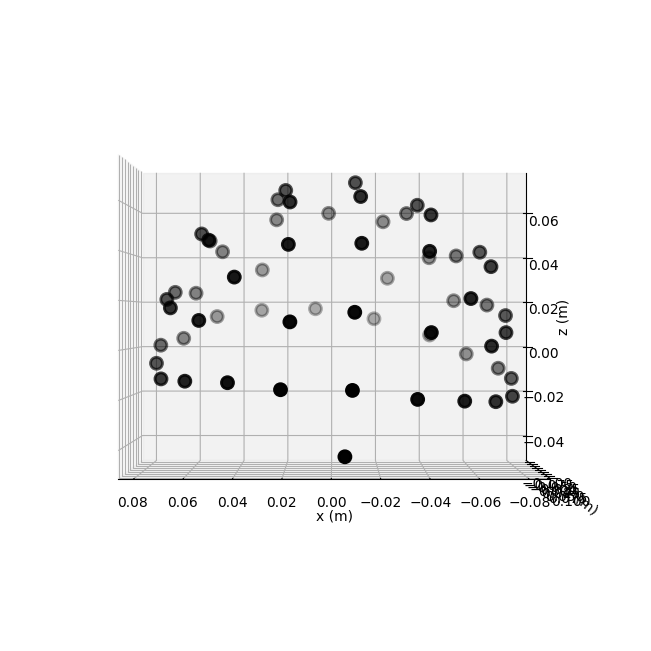

In [14]:
epochs.plot_sensors(kind='3d')

In [ ]:
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
info = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif'
mne.gui.coregistration(subject=subject,
                       subjects_dir=subjects_dir,
                       inst=info,
                    #    orient_to_surface=True,
                    #    scale_by_distance=True
                       )


Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub24\bem\s1_pac_sub24-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub24\bem\s1_pac_sub24-fiducials.fif.
Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif.
Loading MRI fiducials from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif... Done!
Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub24\bem\s1_pac_sub24-

Aligning using fiducials
Start median distance:   9.43 mm
End   median distance: 28962.02 mm
Fitting fiducials finished in 0.10 seconds.
Channel types::	eeg: 60
Aligning using ICP
Start     median distance: 28962.02 mm
  ICP  1  median distance: 4820.87 mm
Fitting ICP - iteration 1
Channel types::	eeg: 60
  ICP  2  median distance: 4822.41 mm
Fitting ICP - iteration 2
Channel types::	eeg: 60
  ICP  3  median distance: 4822.66 mm
Fitting ICP - iteration 3
Channel types::	eeg: 60
  ICP  4  median distance: 4822.66 mm
Fitting ICP - iteration 4
Channel types::	eeg: 60
End       median distance: 4822.66 mm
Fitting ICP finished in 0.38 seconds and 4 iterations.


PLOT BEM SURFACES - optional

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


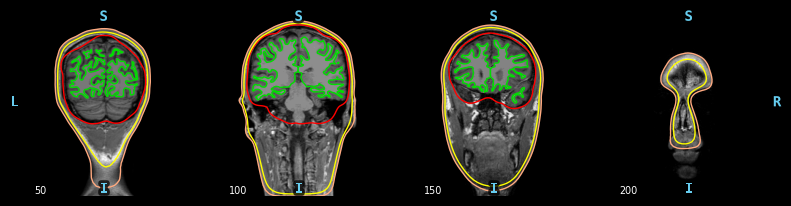

In [64]:
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=fs_subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

CHECK COREGISTRATION

In [ ]:
info = epochs.info
trans_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\analysis\\{subject}-trans.fif'
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info,
    trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=subjects_dir,
    surfaces=["head-dense"],
)

COMPUTE SOURCE SPACE

In [ ]:
# Set up the source space
src = mne.setup_source_space(
    subject, spacing="ico4", add_dist="patch", subjects_dir=subjects_dir
)
print(src)

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


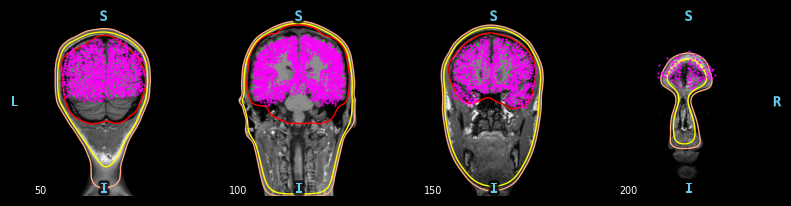

In [187]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

In [225]:
fig = mne.viz.plot_alignment(
    subject=subject,
    subjects_dir=subjects_dir,
    surfaces="white",
    coord_frame="mri",
    src=src,
)
mne.viz.set_3d_view(
    fig,
    azimuth=173.78,
    elevation=101.75,
    distance=0.30,
    focalpoint=(-0.03, -0.01, 0.03),
)

In [ ]:
# BEM model
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(
    subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir
)
bem = mne.make_bem_solution(model)

In [ ]:
# Forward solution
fwd = mne.make_forward_solution(
    info,
    trans=trans,
    src=src,
    bem=bem,
    eeg=True,
    n_jobs=-1,
    # verbose=True,
)
print(fwd)

In [202]:
print(f"Before: {src}")
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] MRI (surface RAS) coords, subject 's1_pac_sub01', ~25.3 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] head coords, subject 's1_pac_sub01', ~25.3 MB>


___

! FOR EACH EPOCHS FILE

In [ ]:
# For each recording ! 
# Noise covariance matrix
noise_cov = mne.compute_covariance(epochs, tmax=0, method='empirical', rank=None) # method='empirical' for optimal regularisation
noise_cov.plot(epochs.info)

evoked = epochs.average()
evoked.plot_white(noise_cov, time_unit="s")

# Compute the inverse operator
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=0.2)

# Compute the source estimates: on evoked data (!)
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1. / 9.)
stc.plot()
